<a href="https://colab.research.google.com/github/EthanBrewerCity/NLP_CW_210008199/blob/main/NLP_CW_210008199.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NLP Project: Ethan Brewer <br>
Dataset: Dair-ai/emotion <br>
Project Type: Sentiment Analysis <br>


# Model 1 : DistilBERT:
Add Setup Features for Project <br>
This Includes device setup, installs, imports and loading the original dataset

In [1]:
# Installs necessary
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
# Add imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Further imports via pytorch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW as Adam # Import AdamW optimiser as previous instance was "deprecated"

# Imports from prior pip installs
from datasets import load_dataset
from transformers import DistilBertModel, DistilBertTokenizer, AdamW # AdamW on this version is stated as "Deprecated" so other version from torch.optim is used

# Sklearn imports
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load Dataset: dair-ai/emotion from Huggingface
dataset = load_dataset('emotion', trust_remote_code=True)

# Ensure the device being used is either the cuda or cpu (if cuda isn't available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Preprocessing the Data
The Tokeniser and Model are taken and the data is preprocessed via BERT (Currently Distilled)

In [3]:
# Load Tokeniser and Model for dataset, In this case, BERT (Distilled vers. may change later)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Create the Neural Network and Define the Model Architecture

In [4]:
# Defining Model Architecture
class SentiClass(nn.Module):
  def __init__(self,model):
    super(SentiClass, self).__init__()
    self.model = model
    self.linear = nn.Linear(768,6)
  def forward(self,input_ids, attention_mask):
    outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
    last_hidden_state = outputs[0]
    logits = self.linear(last_hidden_state[:,0,:])
    return logits

# Creating intstance of the model
model = SentiClass(model)

## Define the Train, Eval and Eval for confusion matrix

In [5]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = dataset['train'].map(tokenize, batched=True)
test_dataset = dataset['test'].map(tokenize, batched=True)

# Set the data format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Set up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=5e-5,weight_decay=0.01)
# Old Loss function, not usable as it is binary
#loss_fn = nn.BCEWithLogitsLoss()
#New loss function
loss_fn = nn.CrossEntropyLoss()

# Define the training loop and prepare data for loss graph
def train(model, train_loader, optimizer, loss_fn, device,num_epochs):
    model.train()
    train_losses=[]
    for epoch in range(num_epochs):
      epoch_loss= 0.0
      for batch in train_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask)
          loss = loss_fn(outputs, labels.long())
          print(loss)
          loss.backward()
          optimizer.step()

          epoch_loss+=loss.item()
      epoch_loss /= len(train_loader)
      train_losses.append(epoch_loss)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    return train_losses

# Define the evaluation loop
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs,dim=1)

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    return correct / total

def eval_conf_matrix(model, test_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      print("Labels:", labels)

      outputs = model(input_ids, attention_mask)
      print("Outputs:", outputs)
      print("Outputs shape:", outputs.shape)
      predictions = torch.argmax(outputs, dim=1).cpu().numpy()

      all_preds.extend(predictions)
      all_labels.extend(labels.cpu().numpy())

  # Check expected range of class indices
  print("Min Label:", np.min(all_labels))
  print("Max Label:", np.max(all_labels))

  # Print true labels and predictions for inspection
  print("True Labels:", all_labels)
  print("Predictions:", all_preds)

  return all_labels, all_preds

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

##Training the model, adding padding and producing results for BERT

tensor(1.8116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7385, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5564, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6204, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5747, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9548, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5738, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2134, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4668, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1958, device='cuda:0', grad_fn=

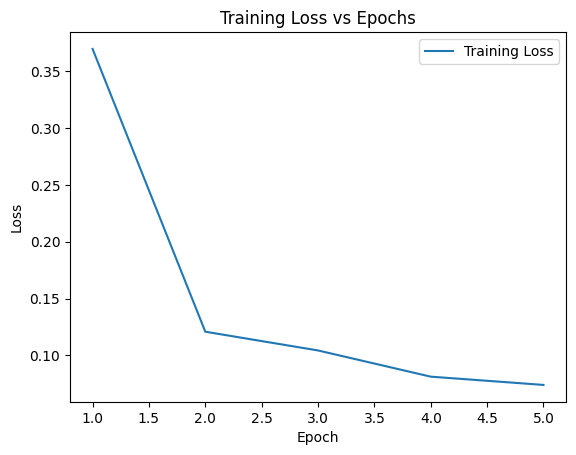

Labels: tensor([0, 0, 0, 1, 0, 4, 3, 1, 1, 3, 4, 0, 4, 1, 2, 0, 1, 0, 3, 1, 0, 1, 1, 0,
        0, 4, 3, 0, 4, 3, 4, 3], device='cuda:0')
Outputs: tensor([[ 7.8809, -0.5539, -1.7598, -3.2079, -2.1132, -1.3293],
        [ 7.8845, -0.4237, -2.4474, -2.9632, -1.7226, -1.4864],
        [ 7.8310, -2.0925, -2.1106, -2.8918,  0.0807, -1.3734],
        [-0.9239,  8.1572,  0.2634, -2.6305, -3.0129, -1.6842],
        [ 7.8990, -1.2460, -2.3077, -3.3038, -0.8757, -1.0957],
        [-1.3965, -1.5356, -1.7433, -2.1497,  7.8628,  0.3887],
        [-2.7691, -0.3075, -1.9343,  3.6008,  4.9490, -2.2417],
        [-0.4614,  6.8349,  1.3861, -2.1546, -2.9305, -2.2132],
        [-2.5465,  8.2647, -0.9618, -2.4344, -2.0195, -0.1847],
        [-1.8852, -0.8505, -2.2358,  7.6229, -0.0651, -2.2682],
        [-1.7784, -0.7728, -1.7741,  4.5565,  3.5678, -2.9538],
        [ 7.3638, -0.5002, -0.7142, -3.2547, -2.0498, -1.9811],
        [ 2.3753, -2.3648, -1.2065, -3.5831,  4.3896,  0.6879],
        [-1.0287,  8.

<Figure size 640x480 with 0 Axes>

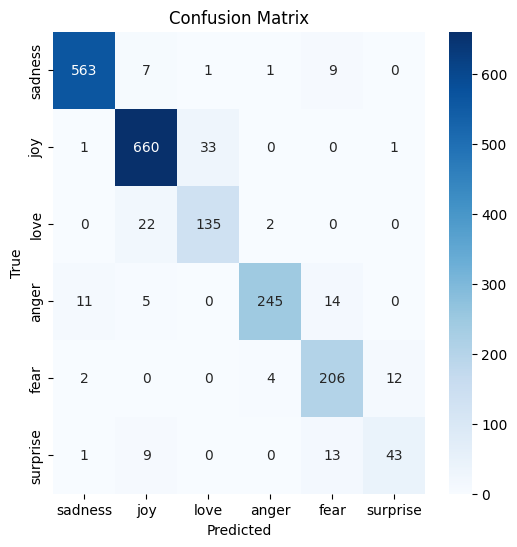

In [6]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Pad the sequences
def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  labels = [item['label'] for item in batch]

  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  attention_mask = pad_sequence(attention_mask,batch_first=True,padding_value=0)

  return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'label': torch.tensor(labels)
  }

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle = False, collate_fn = collate_fn)
# Set number of epochs
epoch_val = 5
history = train(model, train_loader, optimizer, loss_fn, device,epoch_val)
accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.3f}')

# Loss graph for training
plt.figure(1)
plt.plot(range(1, epoch_val + 1), history , label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.show()


# Confusion matrix
plt.figure(2)
true_labels, predictions = eval_conf_matrix(model, test_loader, device)

# Compute confusion matrix - Not needed
#conf_mat = confusion_matrix(true_labels, predictions)

# Print confusion matrix - Debug test
#print("Confusion Matrix:", conf_mat)

conf_mat = confusion_matrix(true_labels,predictions)
plt.figure(figsize = (6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset['train'].features['label'].names,
            yticklabels=dataset['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#for epoch in range(5):
#    history = train(model, train_loader, optimizer, loss_fn, device,epoch_val)
#    accuracy = evaluate(model, test_loader, device)
#    print(f'Epoch {epoch+1} - Test Accuracy: {accuracy:.3f}')